In [1]:
import os
import torch
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def dataset_loader(batch_size, shuffle_test=False):
    # Define data transformations for training and testing
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    transform_test = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Define dataset paths
    dataset_dir = '/content/drive/MyDrive/Datasets/Dataset_2'

    # Load the dataset using ImageFolder
    dataset = torchvision.datasets.ImageFolder(dataset_dir)

    # Construct class labels and their corresponding folder paths
    class_labels = []
    for folder in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, folder)):
            for subfolder in os.listdir(os.path.join(dataset_dir, folder)):
                class_labels.append((f"{folder}_{subfolder}", os.path.join(dataset_dir, folder, subfolder)))

    # Set the dataset classes and class_to_idx
    dataset.classes = [label for label, _ in class_labels]
    dataset.class_to_idx = {cls: idx for idx, cls in enumerate(dataset.classes)}

    # Split the dataset into training and test sets with an 80-20 ratio
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Apply the transformations to the datasets
    train_dataset.dataset.transform = transform_train
    test_dataset.dataset.transform = transform_test

    # Define data loaders for training and test sets
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle_test, pin_memory=True)

    return train_loader, test_loader

In [4]:
def train_model(num_epochs, model, train_loader, criterion, optimizer):
    # Training loop
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: {}".format(device))
    model.to(device)

    total_steps = len(train_loader)
    losses = 0
    train_loss = []
    train_accuracy = []

    for epoch in range(num_epochs):

        losses = 0
        total = 0
        correct = 0

        for i, data in enumerate(train_loader):
            images, labels = data[0].to(device), data[1].to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            losses += loss.item()

            # Backprop and optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Train accuracy
            total += labels.size(0)
            _,predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

        mean_loss_epoch = losses/total_steps
        print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, mean_loss_epoch,
                    (correct / total) * 100))


        train_loss.append(mean_loss_epoch)
        train_accuracy.append((correct / total) * 100)

    return train_loss, train_accuracy, model

# Optimization using Grid Search

Grid search is an exhaustive hyperparameter tuning technique that systematically explores a predefined grid of possible values for each hyperparameter to find the optimal combination that produces the best model performance.

## 1) Learning rate

Perform a grid search over learning rate. Using learning rate = {0.01, 0.001, 0.0003}.

In [5]:
# Define the dictionaries to store the train loss and train accuracy for different learning rates
train_loss_hyper_paramaters = {}
train_acc_hyper_paramaters = {}

# Define the hyperparameters to be tested
hyper_parameters = {"learning_rate": [0.01, 0.001, 0.0003]}

# Set the number of epochs, batch size, and weight decay
num_epochs = 15
batch_size = 32
weight_decay_value = 0.0001

# Iterate over the different learning rates
for learning_rate in hyper_parameters["learning_rate"]:
    print(f'Results of the learning rate = {learning_rate}')

    # Define the model, criterion, and optimizer
    model = models.mobilenet_v3_large(weights=None)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_value)

    # Load the second dataset
    train_loader, test_loader = dataset_loader(batch_size)

    # Call the train model function to train the model
    train_loss, train_accuracy, model = train_model(num_epochs, model, train_loader, criterion, optimizer)

    # Store the train loss and train accuracy in the respective dictionaries
    train_loss_hyper_paramaters[f"lr{learning_rate}"] = train_loss
    train_acc_hyper_paramaters[f"lr{learning_rate}"] = train_accuracy

Results of the learning rate = 0.01
Device: cuda:0
Epoch [1/15], Loss: 2.5344, Accuracy: 24.28%
Epoch [2/15], Loss: 1.8065, Accuracy: 31.14%
Epoch [3/15], Loss: 1.7370, Accuracy: 35.77%
Epoch [4/15], Loss: 1.6776, Accuracy: 37.68%
Epoch [5/15], Loss: 1.6012, Accuracy: 40.11%
Epoch [6/15], Loss: 1.6260, Accuracy: 39.75%
Epoch [7/15], Loss: 1.4994, Accuracy: 44.90%
Epoch [8/15], Loss: 1.5150, Accuracy: 44.54%
Epoch [9/15], Loss: 1.4840, Accuracy: 48.48%
Epoch [10/15], Loss: 1.4040, Accuracy: 50.43%
Epoch [11/15], Loss: 1.3066, Accuracy: 52.94%
Epoch [12/15], Loss: 1.2219, Accuracy: 57.94%
Epoch [13/15], Loss: 1.1903, Accuracy: 57.08%
Epoch [14/15], Loss: 1.2756, Accuracy: 55.99%
Epoch [15/15], Loss: 1.1512, Accuracy: 59.07%
Results of the learning rate = 0.001
Device: cuda:0
Epoch [1/15], Loss: 1.8589, Accuracy: 44.78%
Epoch [2/15], Loss: 1.0327, Accuracy: 64.07%
Epoch [3/15], Loss: 0.8663, Accuracy: 71.66%
Epoch [4/15], Loss: 0.7455, Accuracy: 74.99%
Epoch [5/15], Loss: 0.6801, Accuracy

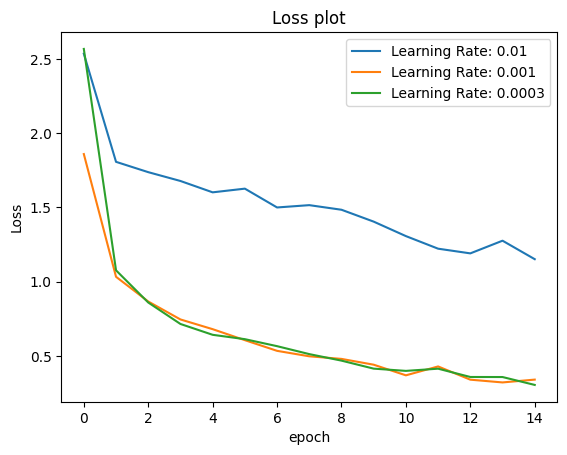

In [6]:
# Plot the training loss
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

# Iterate over the different learning rates
for learning_rate in hyper_parameters["learning_rate"]:
    plt.plot(epochs, train_loss_hyper_paramaters[f'lr{learning_rate}'], label=f'Learning Rate: {learning_rate}')

plt.legend()

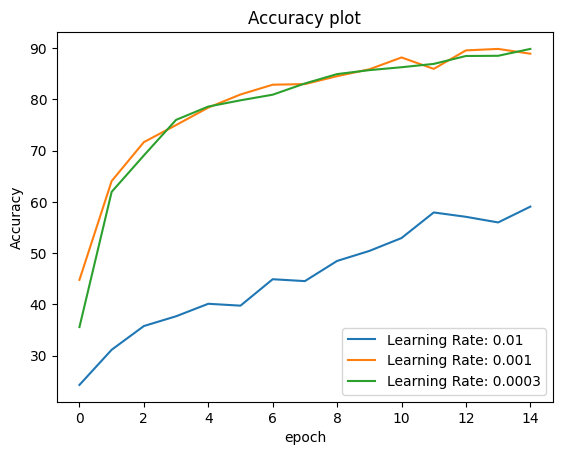

In [7]:
# Plot the training accuracies
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

# Iterate over the different learning rates
for learning_rate in hyper_parameters["learning_rate"]:
    plt.plot(epochs, train_acc_hyper_paramaters[f'lr{learning_rate}'], label=f'Learning Rate: {learning_rate}')

plt.legend()

## 2) Batch Size

Perform a grid search over learning rate. Using batch size = {32, 64, 128}.

In [ ]:
# Define the dictionaries to store the train loss and train accuracy for different batch sizes
train_loss_hyper_paramaters = {}
train_acc_hyper_paramaters = {}

# Define the hyperparameters to be tested
hyper_parameters = {"batch_size": [32, 64, 128]}

# Set the number of epochs, learning rate, and weight decay
num_epochs = 15
learning_rate = 3e-4
weight_decay_value = 0.0001

# Iterate over the different batch sizes
for batch_size in hyper_parameters["batch_size"]:
    print(f'Results of the batch size = {batch_size}')

    # Define the model, criterion, and optimizer
    model = models.mobilenet_v3_large(weights=None)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_value)

    # Load the second dataset
    train_loader, test_loader = dataset_loader(batch_size)

    # Call the train model function to train the model
    train_loss, train_accuracy, model = train_model(num_epochs, model, train_loader, criterion, optimizer)

    # Store the train loss and train accuracy in the respective dictionaries
    train_loss_hyper_paramaters[f"b{batch_size}"] = train_loss
    train_acc_hyper_paramaters[f"b{batch_size}"] = train_accuracy

Results of the batch size = 32
Device: cuda:0
Epoch [1/15], Loss: 2.5149, Accuracy: 38.29%
Epoch [2/15], Loss: 1.0804, Accuracy: 60.50%
Epoch [3/15], Loss: 0.8142, Accuracy: 70.69%
Epoch [4/15], Loss: 0.7433, Accuracy: 75.27%
Epoch [5/15], Loss: 0.6097, Accuracy: 80.31%
Epoch [6/15], Loss: 0.5770, Accuracy: 80.23%
Epoch [7/15], Loss: 0.5505, Accuracy: 81.69%
Epoch [8/15], Loss: 0.4693, Accuracy: 85.18%
Epoch [9/15], Loss: 0.4720, Accuracy: 84.61%
Epoch [10/15], Loss: 0.4146, Accuracy: 86.16%
Epoch [11/15], Loss: 0.3975, Accuracy: 87.17%
Epoch [12/15], Loss: 0.3794, Accuracy: 87.74%
Epoch [13/15], Loss: 0.3226, Accuracy: 90.05%
Epoch [14/15], Loss: 0.3496, Accuracy: 88.23%
Epoch [15/15], Loss: 0.3401, Accuracy: 88.35%
Results of the batch size = 64
Device: cuda:0
Epoch [1/15], Loss: 3.5765, Accuracy: 30.37%
Epoch [2/15], Loss: 1.2289, Accuracy: 55.91%
Epoch [3/15], Loss: 0.9681, Accuracy: 64.88%
Epoch [4/15], Loss: 0.8365, Accuracy: 69.18%
Epoch [5/15], Loss: 0.7241, Accuracy: 74.58%
Ep

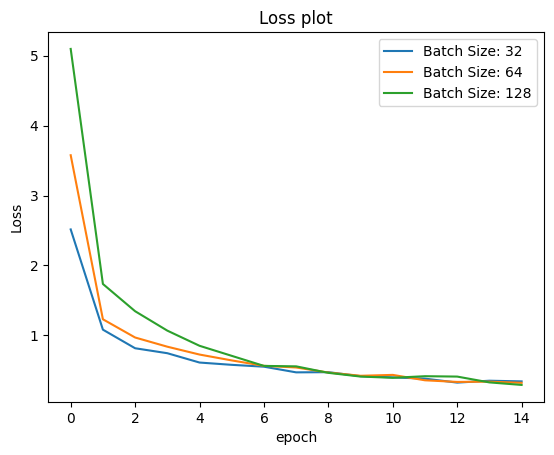

In [ ]:
# Plot the training loss
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

# Iterate over the different batch sizes
for batch_size in hyper_parameters["batch_size"]:
    plt.plot(epochs, train_loss_hyper_paramaters[f'b{batch_size}'], label=f'Batch Size: {batch_size}')

plt.legend()

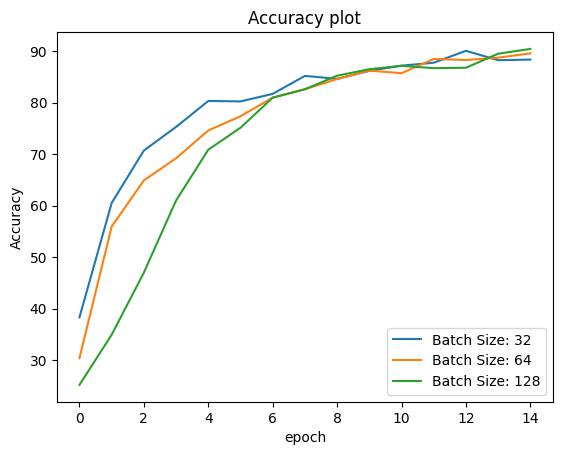

In [ ]:
# Plot the training accuracies
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

# Iterate over the different batch sizes
for batch_size in hyper_parameters["batch_size"]:
    plt.plot(epochs, train_acc_hyper_paramaters[f'b{batch_size}'], label=f'Batch Size: {batch_size}')

plt.legend()

## 3) Loss Function

Perform a grid search over learning rate. Use loss function = {["neg_log_likelihood"](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html), ["cross_entropy"](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)}.

In [ ]:
# Define the dictionaries to store the train loss and train accuracy for different loss functions
train_loss_hyper_paramaters = {}
train_acc_hyper_paramaters = {}

# Define the hyperparameters to be tested
hyper_parameters = {"loss_function": ["neg_log_likelihood", "cross_entropy"]}

# Set the number of epochs, learning rate, batch size, and weight decay
num_epochs = 15
learning_rate = 3e-4
batch_size = 32
weight_decay_value = 0.0001

# Iterate over the different loss functions
for loss_function in hyper_parameters["loss_function"]:
    print(f'Results of the loss function = {loss_function}')

    # Define the model, criterion, and optimizer
    model = models.mobilenet_v3_large(weights=None)
    if loss_function == "neg_log_likelihood":
        criterion = torch.nn.NLLLoss()
    elif loss_function == "cross_entropy":
        criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_value)

    # Load the second dataset
    train_loader, test_loader = dataset_loader(batch_size)

    # Call the train model function to train the model
    train_loss, train_accuracy, model = train_model(num_epochs, model, train_loader, criterion, optimizer)

    # Store the train loss and train accuracy in the respective dictionaries
    train_loss_hyper_paramaters[f"lfn{loss_function}"] = train_loss
    train_acc_hyper_paramaters[f"lfn{loss_function}"] = train_accuracy

Results of the loss function = neg_log_likelihood
Device: cuda:0
Epoch [1/15], Loss: -44.0516, Accuracy: 28.70%
Epoch [2/15], Loss: -494.2904, Accuracy: 30.45%
Epoch [3/15], Loss: -1728.6221, Accuracy: 32.16%
Epoch [4/15], Loss: -3989.1055, Accuracy: 32.03%
Epoch [5/15], Loss: -7498.5409, Accuracy: 31.79%
Epoch [6/15], Loss: -12408.6671, Accuracy: 32.20%
Epoch [7/15], Loss: -18848.8356, Accuracy: 31.79%
Epoch [8/15], Loss: -27921.3969, Accuracy: 33.01%
Epoch [9/15], Loss: -39082.2824, Accuracy: 32.76%
Epoch [10/15], Loss: -52849.8800, Accuracy: 32.81%
Epoch [11/15], Loss: -68493.2519, Accuracy: 31.18%
Epoch [12/15], Loss: -87272.9952, Accuracy: 32.24%
Epoch [13/15], Loss: -110667.8409, Accuracy: 32.81%
Epoch [14/15], Loss: -136172.7938, Accuracy: 33.05%
Epoch [15/15], Loss: -167766.7977, Accuracy: 33.66%
Results of the loss function = cross_entropy
Device: cuda:0
Epoch [1/15], Loss: 2.5315, Accuracy: 38.37%
Epoch [2/15], Loss: 1.1287, Accuracy: 60.66%
Epoch [3/15], Loss: 0.9159, Accura

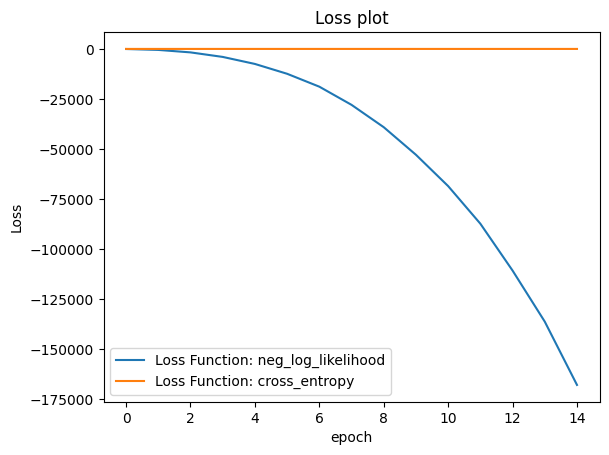

In [ ]:
# Plot the training loss
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

# Iterate over the different loss functions
for loss_function in hyper_parameters["loss_function"]:
    plt.plot(epochs, train_loss_hyper_paramaters[f'lfn{loss_function}'], label=f'Loss Function: {loss_function}')

plt.legend()

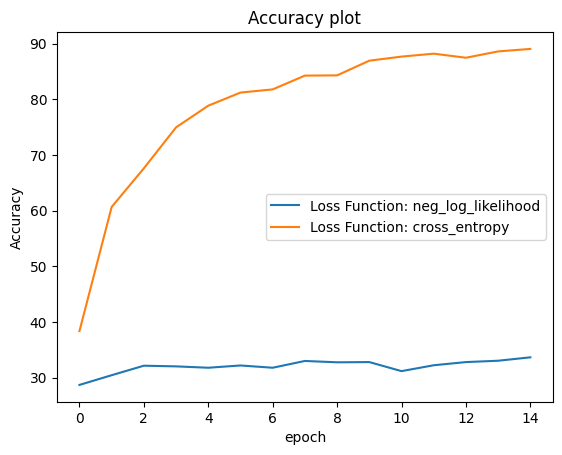

In [ ]:
# Plot the training accuracies
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

# Iterate over the different loss functions
for loss_function in hyper_parameters["loss_function"]:
    plt.plot(epochs, train_acc_hyper_paramaters[f'lfn{loss_function}'], label=f'Loss Function: {loss_function}')

plt.legend()